## Import dependencies

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas_datareader as pdr
from datetime import datetime
import pandas as pd
import scipy.stats as st
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from functools import partial
from scipy.integrate import quad

from matplotlib import pyplot as plt
import utils
import alPhaStablePricer as alpha
import ghPricer as gh
import mertonPricer as merton

## Read data

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-06-10,24.837500,24.620001,24.632500,24.707500,126851600.0,23.081377
2016-06-13,24.780001,24.275000,24.672501,24.334999,152082000.0,22.733387
2016-06-14,24.620001,24.187500,24.330000,24.365000,127727600.0,22.761415
2016-06-15,24.602501,24.257500,24.455000,24.285000,117780800.0,22.686680
2016-06-16,24.437500,24.017500,24.112499,24.387501,125307200.0,22.782436
...,...,...,...,...,...,...
2021-06-03,124.849998,123.129997,124.680000,123.540001,76229200.0,123.540001
2021-06-04,126.160004,123.849998,124.070000,125.889999,75087300.0,125.889999
2021-06-07,126.320000,124.830002,126.169998,125.900002,71057600.0,125.900002


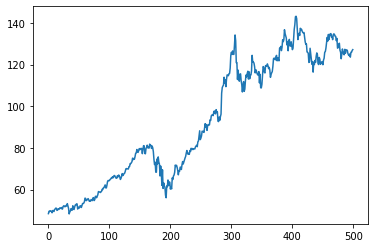

In [2]:
df = pdr.data.DataReader("AAPL",'yahoo', #"av-intraday",
                         end=datetime.today(),
                         api_key="ZDT39A5EINVODTVI")
display(df)
df["Close"][-500:].plot(use_index=False)
initial_value=df["Close"][-1]
df.index = pd.to_datetime(df.index)

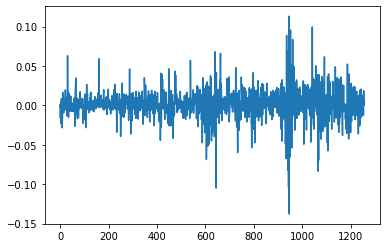

Date
2016-06-13   -0.015191
2016-06-14    0.001232
2016-06-15   -0.003289
2016-06-16    0.004212
2016-06-17   -0.023021
Name: Close, dtype: float64

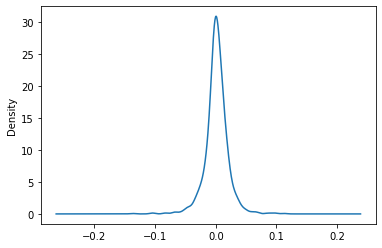

In [3]:
df = pd.Series(np.log(df.Close) - np.log(df.Close.shift(1))[1:],index=df.index[1:])
df.plot(use_index=False)
plt.show()
df.plot.kde()
df.head()

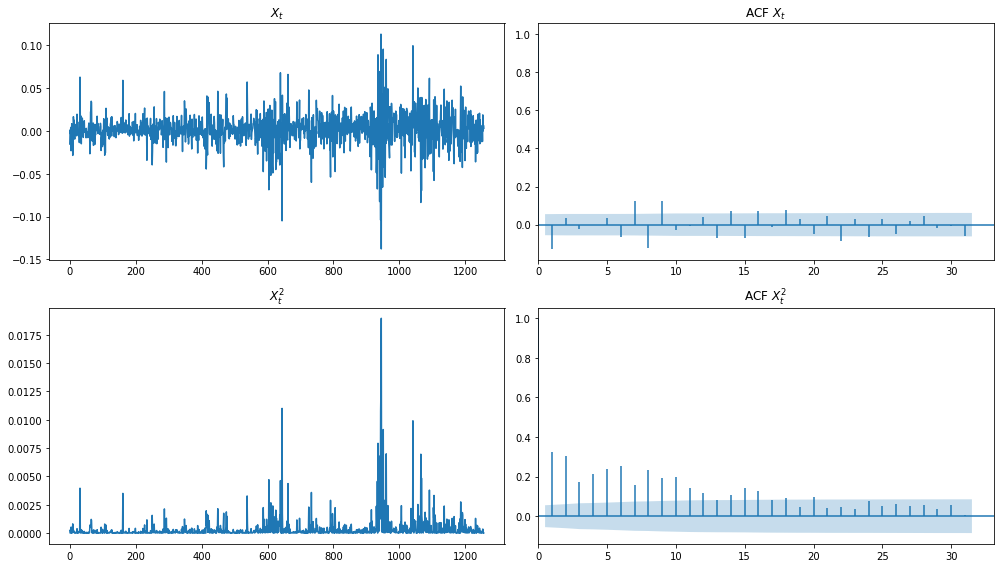

In [4]:
def tsplot(y, figsize=(14, 8),xlim=(-0.1,0.1)):

    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax   = plt.subplot2grid(layout, (0, 0))
    ac_ax = plt.subplot2grid(layout, (0, 1))
    ts_ax2  = plt.subplot2grid(layout, (1, 0))
    ac_ax2 = plt.subplot2grid(layout, (1, 1))
    
    y2=pd.Series([x**2 for x in y])

    y.plot(ax=ts_ax,use_index=False,title=r'$X_t$')
    y2.plot(ax=ts_ax2,use_index=False,title=r'$X_t^2$')
    
    smt.graphics.plot_acf(y, lags=None, ax=ac_ax,marker=None,title=r'ACF $X_t$')
    smt.graphics.plot_acf(y2, lags=None, ax=ac_ax2,marker=None,title=r'ACF $X_t^2$')
    
    [ax.set_xlim(0) for ax in [ac_ax, ac_ax2]]

    
    fig.tight_layout()
    plt.show()
tsplot(df)

## Data subset

In [5]:
dataset = df[-253:]

In [6]:
dataset

Date
2020-06-09    0.031090
2020-06-10    0.025402
2020-06-11   -0.049201
2020-06-12    0.008596
2020-06-15    0.012291
                ...   
2021-06-03   -0.012229
2021-06-04    0.018844
2021-06-07    0.000079
2021-06-08    0.006650
2021-06-09    0.003072
Name: Close, Length: 253, dtype: float64

In [7]:
print("Shapiro test of normality: statistic={}, p_value={}".format(st.shapiro(dataset)[0],st.shapiro(dataset)[1]))

Shapiro test of normality: statistic=0.9789115786552429, p_value=0.0008237912552431226


In [8]:
print("Jarque Bera test of normality: statistic={}, p_value={}".format(st.jarque_bera(dataset)[0],st.shapiro(dataset)[1]))

Jarque Bera test of normality: statistic=41.63550242295943, p_value=0.0008237912552431226


We can reject the null hypothesis H0 that the returns are normally distributed

## Fit models

In [9]:
alpha_model = alpha.AlPhaStablePricer()

In [10]:
alpha_model.fit(dataset)

In [11]:
merton_model = merton.MertonPricer()

In [12]:
merton_model.fit(dataset,T=1)

In [13]:
gh_model = gh.GhPricer()

In [14]:
gh_model.fit(dataset,100)

## Probability density

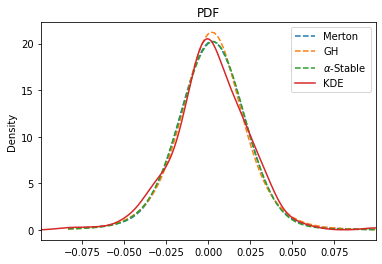

In [15]:
N=100
x_grid = np.linspace(dataset.min(),dataset.max(),N)

plt.plot(x_grid,
        [merton_model.Merton_density(j,
                                     T=1,
                                     lam= merton_model.lam,
                                     mu=merton_model.mu,
                                     muJ=merton_model.muJ,
                                     sig=merton_model.sig,
                                     sigJ=merton_model.sigJ) for j in x_grid],
        label="Merton",linestyle='--')

plt.plot(x_grid,
        [gh_model.GH_density(j,
                             alpha= gh_model.alpha,
                             betta=gh_model.betta,
                             delta=gh_model.delta,
                             lam=gh_model.lam,
                             mu=gh_model.mu) for j in x_grid],
        label="GH",linestyle='--')



plt.plot(x_grid,
         [st.levy_stable.pdf(x, 
                          alpha=alpha_model.alpha,
                          beta=alpha_model.betta,
                          loc=alpha_model.mu,
                          scale=alpha_model.c) for x in x_grid],
        label=r'$\alpha$-Stable',linestyle='--')

dataset.plot.kde(label="KDE")
plt.xlim((-dataset.max(),dataset.max()))
plt.legend()
plt.title("PDF")
plt.show()

## Cumulative distribution function

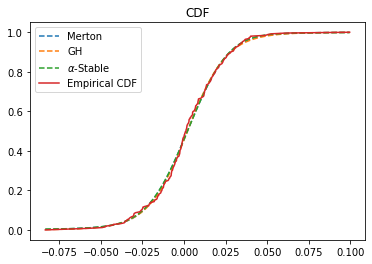

In [16]:
p_Merton = partial(merton_model.Merton_density,
                  T=1,
                  lam= merton_model.lam,
                  mu=merton_model.mu,
                  muJ=merton_model.muJ,
                  sig=merton_model.sig,
                  sigJ=merton_model.sigJ)

p_GH = partial(gh_model.GH_density,
               delta=gh_model.delta,
               mu=gh_model.mu,
               lam=gh_model.lam,
               alpha=gh_model.alpha,
               betta=gh_model.betta)


plt.plot(x_grid,
        [quad(p_Merton,-np.inf,x)[0] for x in x_grid],
        label="Merton",linestyle='--')

plt.plot(x_grid,
        [quad(p_GH,-np.inf,x)[0] for x in x_grid],
        label="GH",linestyle='--')

plt.plot(x_grid,  
        [st.levy_stable(alpha=alpha_model.alpha,
                        beta=alpha_model.betta,
                        loc=alpha_model.mu,
                        scale=alpha_model.c).cdf(x) for x in x_grid],
        label=r'$\alpha$-Stable',linestyle='--')
 
plt.plot(np.sort(dataset), 1. * np.arange(len(dataset)) / (len(dataset) - 1),label="Empirical CDF")
plt.legend()
plt.title("CDF")
plt.show()

### AIC

In [17]:
pd.DataFrame({"Merton":merton_model.aic,"GH":gh_model.aic,"Alpha-Stable":alpha_model.aic}.items(),
             columns=["Model","AIC"]).sort_values("AIC")

,Model,AIC
2,Alpha-Stable,-1216.867449
0,Merton,-1216.087549
1,GH,-1215.780867


## Pricing

In [34]:
r=1.5/100
S0=initial_value
K=127
T=12/250
print(S0)
print(T)

127.12999725341797
0.048


###  Martingale corrections

In [35]:
cf_stable_mcm = alpha_model.cf_stable(
                        t=T,
                        alpha=alpha_model.alpha,
                        betta=alpha_model.betta,
                        mu=alpha_model.mu-alpha_model.mcm,
                        c=alpha_model.c)

cf_mert_mcm = partial(merton_model.cf_mert,
                       t=T,
                       mu= merton_model.mu-merton_model.mcm,
                       sig= merton_model.sig,
                       lam= merton_model.lam,
                       muJ= merton_model.muJ,
                       sigJ= merton_model.sigJ)
cf_GH_mcm = partial(gh_model.cf_GH,
                    t=T,
                    delta = gh_model.delta,               
                    mu= gh_model.mu-gh_model.mcm,
                    lam= gh_model.lam,
                    alpha=gh_model.alpha,
                    betta=gh_model.betta)
print(alpha_model.mcm)
print(merton_model.mcm)
print(gh_model.mcm)

(-0.000383841487839542+0.0013674312479988729j)
(0.0019112405777681008+0j)
(0.20969561469862136+0j)


### Results

In [36]:
data = [{'model': "Stable",
         "Call_Fourier":utils.fourierPricer(K=K,S0=S0,r=r,cf=cf_stable_mcm,payoff="call",T=T,udep=False),
         "Call_MC":alpha_model.mcPricer(K=K,r=r,T=T,S0=S0,payoff="call",N=10000)[0],
         "Put_Fourier":utils.fourierPricer(K=K,S0=S0,r=r,cf=cf_stable_mcm,payoff="put",T=T,udep=False),
         "Put_MC":alpha_model.mcPricer(K=K,r=r,T=T,S0=S0,payoff="put",N=10000)[0]},
       {'model': "Merton",
         "Call_Fourier":utils.fourierPricer(K=K,S0=S0,r=r,cf=cf_mert_mcm,payoff="call",T=T,udep=True),
         "Call_MC":merton_model.mcPricer(K=K,r=r,T=T,S0=S0,payoff="call",N=10000)[0],
         "Put_Fourier":utils.fourierPricer(K=K,S0=S0,r=r,cf=cf_mert_mcm,payoff="put",T=T,udep=True),
         "Put_MC":merton_model.mcPricer(K=K,r=r,T=T,S0=S0,payoff="put",N=10000)[0]},
       {'model': "GH",
         "Call_Fourier":utils.fourierPricer(K=K,S0=S0,r=r,cf=cf_GH_mcm,payoff="call",T=T,udep=True),
         #"Call_MC":gh_model.mcPricer(K=K,r=r,T=T,S0=S0,payoff="call",N=1)[0],
         "Put_Fourier":utils.fourierPricer(K=K,S0=S0,r=r,cf=cf_GH_mcm,payoff="put",T=T,udep=True),
         #"Put_MC":gh_model.mcPricer(K=K,r=r,T=T,S0=S0,payoff="put",N=1)[0]
       }]
        
pd.DataFrame.from_dict(data)

,model,Call_Fourier,Call_MC,Put_Fourier,Put_MC
0,Stable,0.206314,1.319278,-0.015090,0.876232
1,Merton,0.377674,0.468238,0.156269,0.314915
2,GH,0.284940,NaN,0.063535,NaN


## Plots

In [ ]:
S = [i for i in range(1,200)]
plots= [{'model': "Stable",
         "Call_Fourier":[utils.fourierPricer(K=K,S0=s,r=r,cf=cf_stable_mcm,payoff="call",T=T,udep=False) for s in S],
         "Call_MC":[alpha_model.mcPricer(K=K,r=r,T=T,S0=s,payoff="call",N=10000)[0] for s in S],
         "Put_Fourier":[utils.fourierPricer(K=K,S0=s,r=r,cf=cf_stable_mcm,payoff="put",T=T,udep=False) for s in S],
         "Put_MC":[alpha_model.mcPricer(K=K,r=r,T=T,S0=s,payoff="put",N=10000)[0]for s in S]},
       {'model': "Merton",
         "Call_Fourier":[utils.fourierPricer(K=K,S0=s,r=r,cf=cf_mert_mcm,payoff="call",T=T,udep=True) for s in S],
         "Call_MC":[merton_model.mcPricer(K=K,r=r,T=T,S0=s,payoff="call",N=10000)[0]for s in S],
         "Put_Fourier":[utils.fourierPricer(K=K,S0=s,r=r,cf=cf_mert_mcm,payoff="put",T=T,udep=True) for s in S],
         "Put_MC":[merton_model.mcPricer(K=K,r=r,T=T,S0=s,payoff="put",N=10000)[0]for s in S]},
       {'model': "GH",
         "Call_Fourier":[utils.fourierPricer(K=K,S0=s,r=r,cf=cf_GH_mcm,payoff="call",T=T,udep=True) for s in S],
         "Call_MC":[gh_model.mcPricer(K=K,r=r,T=T,S0=s,payoff="call",N=1)[0]for s in S],
         "Put_Fourier":[utils.fourierPricer(K=K,S0=s,r=r,cf=cf_GH_mcm,payoff="put",T=T,udep=True) for s in S],
         "Put_MC":[gh_model.mcPricer(K=K,r=r,T=T,S0=s,payoff="put",N=1)[0]for s in S]
       }]

## CALLS

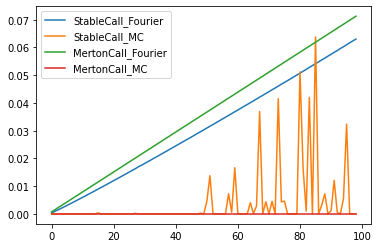

In [40]:
for i in plots:
    for j in i.keys():
        if ((j!="model") and (j!="Put_Fourier") and (j!="Put_MC")):
            if i["model"]!="GH":
                plt.plot(i[j],label=i["model"]+j)
plt.legend()
plt.show()

## Puts

In [ ]:
for i in plots:
    for j in i.keys():
        if ((j!="model") and (j!="Call_Fourier") and (j!="Call_MC")):
            if i["model"]!="GH":
                plt.plot(i[j],label=i["model"]+j)
plt.legend()
plt.show()

In [23]:
from scipy.optimize import fsolve

fsolve(lambda x:2.34-2.15- S0 + K*np.exp(-r*x),x0=1)

array([0.03150495])

In [24]:
6/275

0.02181818181818182